In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.base import clone

np.random.seed(123)

In [2]:
#load the data
train = pd.read_csv('CW1_train.csv')
test  = pd.read_csv('CW1_test.csv')

print(train.shape, test.shape)
train.head()

FileNotFoundError: [Errno 2] No such file or directory: 'CW1_train.csv'

In [ ]:
y = train['outcome']
X = train.drop('outcome', axis=1)

categorical_cols = ['cut', 'color', 'clarity']
numeric_cols = [c for c in X.columns if c not in categorical_cols]

print(f'Features: {X.shape[1]}, Categorical: {categorical_cols}')
print(f'Missing values: {X.isnull().sum().sum()}')

Features: 30, Categorical: ['cut', 'color', 'clarity']
Missing values: 0


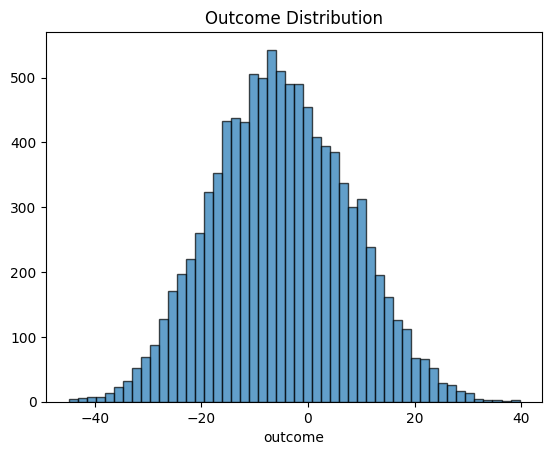

,outcome
count,10000.000000
mean,-4.979081
std,12.722224
min,-44.879471
25%,-13.989962
50%,-5.442794
75%,3.918593
max,39.675966


In [ ]:
#outcome distribution
plt.hist(y, bins=50, edgecolor='black', alpha=0.7)
plt.title('Outcome Distribution')
plt.xlabel('outcome')
plt.show()

y.describe()

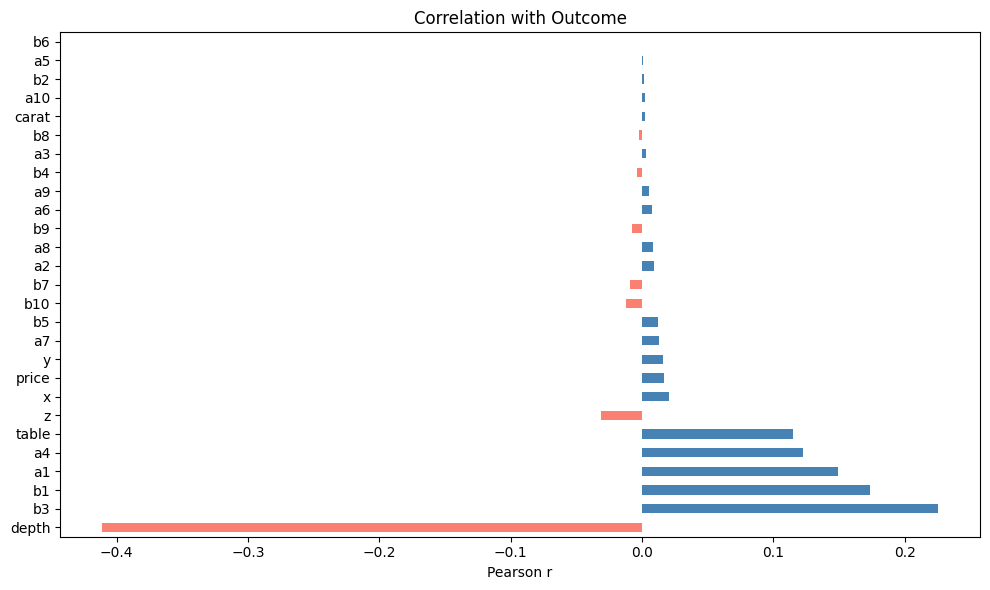

depth   -0.411073
b3       0.225407
b1       0.173719
a1       0.149101
a4       0.122441
Name: outcome, dtype: float64


In [ ]:
#check which features correlate with outcome
corrs = train[numeric_cols + ['outcome']].corr()['outcome'].drop('outcome')
corrs = corrs.reindex(corrs.abs().sort_values(ascending=False).index)

fig, ax = plt.subplots(figsize=(10, 6))
corrs.plot.barh(ax=ax, color=['steelblue' if v > 0 else 'salmon' for v in corrs])
ax.set_title('Correlation with Outcome')
ax.set_xlabel('Pearson r')
plt.tight_layout()
plt.show()

print(corrs.head(5))

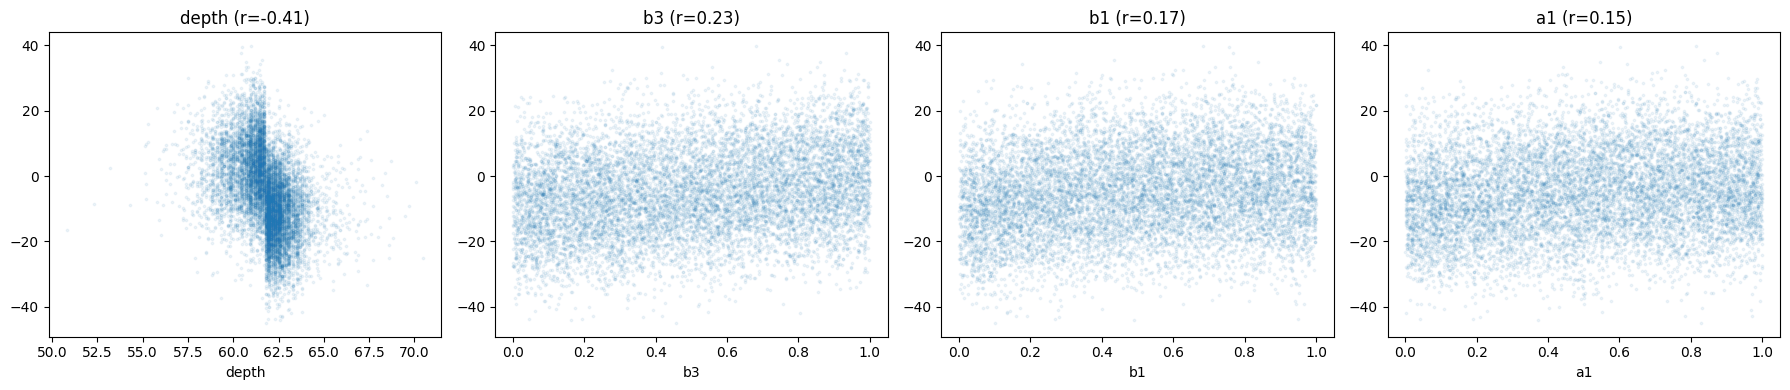

In [ ]:
#scatter plots for the top correlated features
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
for ax, col in zip(axes, ['depth', 'b3', 'b1', 'a1']):
    ax.scatter(train[col], y, alpha=0.07, s=3)
    ax.set_title(f'{col} (r={train[col].corr(y):.2f})')
    ax.set_xlabel(col)
plt.tight_layout()
plt.show()

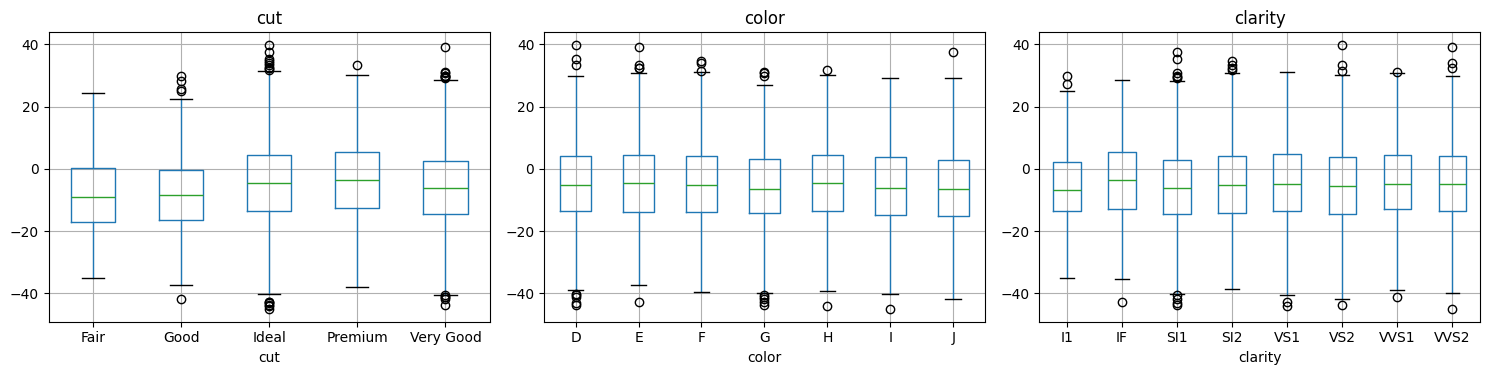

In [ ]:
#boxplots for categorical features
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, col in zip(axes, categorical_cols):
    train.boxplot(column='outcome', by=col, ax=ax)
    ax.set_title(col)
plt.suptitle('')
plt.tight_layout()
plt.show()

In [ ]:
#check for weird values in the diamonds dimensions
print(X[(X['x'] == 0) | (X['y'] == 0) | (X['z'] == 0) | (X['y'] > 15)][['carat','x','y','z','price']])
#only 5 rows, i'll use trees to handle this

      carat     x      y     z  price
2634   1.00  6.55   6.48  0.00   3142
2722   0.71  0.00   0.00  0.00   2130
4729   1.15  6.88   6.83  0.00   5564
8336   2.25  0.00   0.00  0.00  18034
9471   2.00  8.09  58.90  8.06  12210


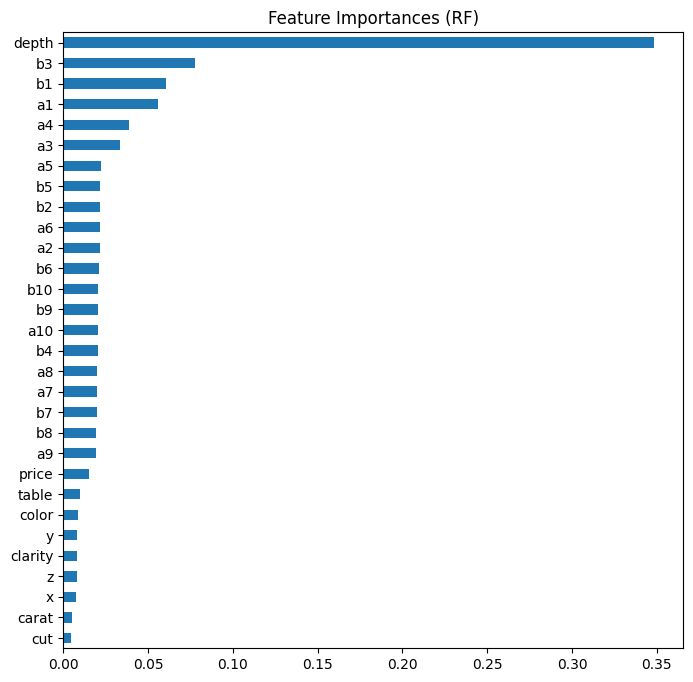

depth    0.348160
b3       0.077963
b1       0.060383
a1       0.056115
a4       0.038620
dtype: float64


In [ ]:
#Random forest to see feature importances
X_temp = X.copy()
oe = OrdinalEncoder()
X_temp[categorical_cols] = oe.fit_transform(X_temp[categorical_cols])

rf_temp = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_temp.fit(X_temp, y)

imp = pd.Series(rf_temp.feature_importances_, index=X.columns).sort_values(ascending=True)
imp.plot.barh(figsize=(8, 8))
plt.title('Feature Importances (RF)')
plt.show()

print(imp.sort_values(ascending=False).head(5))

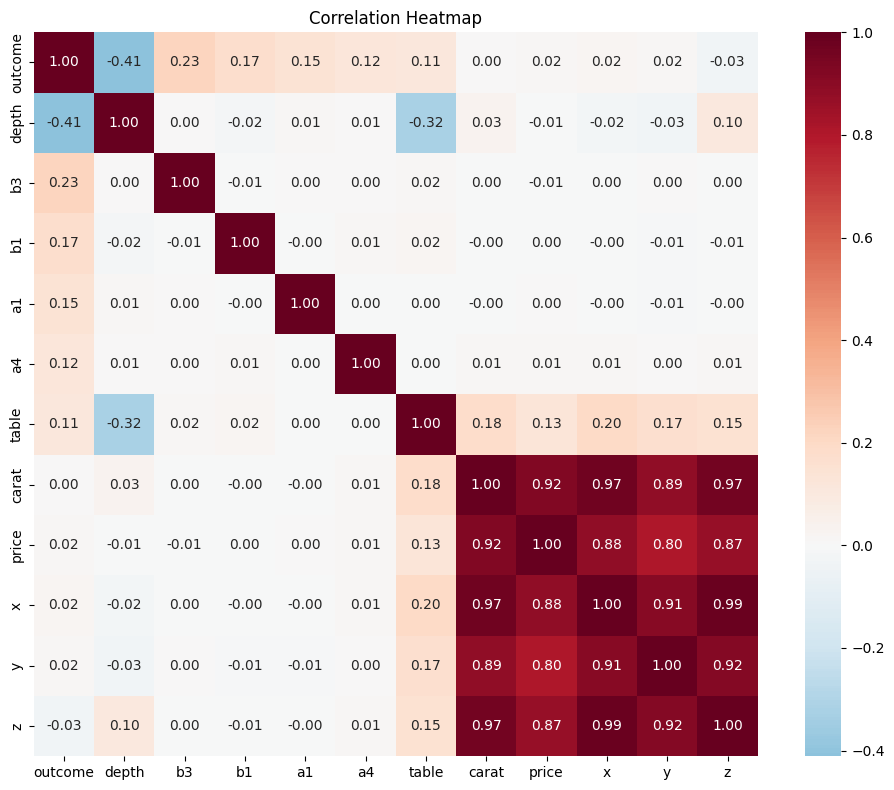

In [ ]:
#Correlation heatmap for the key features
key = ['outcome', 'depth', 'b3', 'b1', 'a1', 'a4', 'table', 'carat', 'price', 'x', 'y', 'z']
plt.figure(figsize=(10, 8))
sns.heatmap(train[key].corr(), annot=True, fmt='.2f', cmap='RdBu_r', center=0, square=True)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

In [ ]:
# Ordinal encode categoricals (fit on train only via pipeline); handle_unknown so test categories not in train don't leak
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
        ('num', 'passthrough', numeric_cols),
    ]
)

In [ ]:
#baseline comparison
from sklearn.linear_model import LinearRegression

baselines = {
    'Linear Regression': Pipeline([('pre', preprocessor), ('m', LinearRegression())]),
    'Random Forest': Pipeline([('pre', preprocessor), ('m', RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))]),
    'HistGBR': Pipeline([('pre', preprocessor), ('m', HistGradientBoostingRegressor(max_iter=500, max_depth=5, learning_rate=0.1, random_state=42))]),
}

for name, pipe in baselines.items():
    scores = cross_val_score(pipe, X, y, cv=5, scoring='r2')
    print(f'{name:25s} R² = {scores.mean():.4f} +- {scores.std():.4f}')

Linear Regression         R² = 0.2777 +- 0.0316
Random Forest             R² = 0.4531 +- 0.0111
HistGBR                   R² = 0.4356 +- 0.0175


In [ ]:
# RF tuning
print('--- Random Forest ---')
for mf in ['sqrt', 0.4, 0.5, 0.6]:
    for leaf in [1, 3, 5]:
        pipe = Pipeline([('pre', preprocessor), ('m', RandomForestRegressor(n_estimators=300, max_features=mf, min_samples_leaf=leaf, random_state=42, n_jobs=-1))])
        s = cross_val_score(pipe, X, y, cv=5, scoring='r2')
        print(f'  feat={str(mf):>5s} leaf={leaf} => R²={s.mean():.4f}')

--- Random Forest ---
  feat= sqrt leaf=1 => R²=0.4492
  feat= sqrt leaf=3 => R²=0.4475
  feat= sqrt leaf=5 => R²=0.4481
  feat=  0.4 leaf=1 => R²=0.4568
  feat=  0.4 leaf=3 => R²=0.4590
  feat=  0.4 leaf=5 => R²=0.4601
  feat=  0.5 leaf=1 => R²=0.4583
  feat=  0.5 leaf=3 => R²=0.4577


In [ ]:
#HistGBR tuning
print('Hist Gradient Boosting')
configs = [
    (500,  4, 0.05, 20),
    (800,  3, 0.05, 20),
    (1000, 3, 0.03, 20),
    (1000, 3, 0.03, 25),
    (1500, 3, 0.02, 20),
    (1200, 3, 0.025, 20),
    (800,  4, 0.03, 25),
]
for itr, d, lr, leaf in configs:
    pipe = Pipeline([('pre', preprocessor), ('m', HistGradientBoostingRegressor(max_iter=itr, max_depth=d, learning_rate=lr, min_samples_leaf=leaf, random_state=42))])
    s = cross_val_score(pipe, X, y, cv=5, scoring='r2')
    print(f'  iter={itr:4d} d={d} lr={lr:.3f} leaf={leaf:2d} => R²={s.mean():.4f}')

In [ ]:
#ensemble 3 HGB variants + 2 RF variants
#different hyperparameters and seeds for diversity
ensemble = {
    'hgb1': Pipeline([('pre', preprocessor), ('m', HistGradientBoostingRegressor(max_iter=1000, max_depth=3, learning_rate=0.03, min_samples_leaf=20, random_state=42))]),
    'hgb2': Pipeline([('pre', preprocessor), ('m', HistGradientBoostingRegressor(max_iter=1500, max_depth=3, learning_rate=0.02, min_samples_leaf=20, random_state=67))]),
    'hgb3': Pipeline([('pre', preprocessor), ('m', HistGradientBoostingRegressor(max_iter=800, max_depth=4, learning_rate=0.03, min_samples_leaf=25, random_state=7))]),
    'rf1':  Pipeline([('pre', preprocessor), ('m', RandomForestRegressor(n_estimators=300, max_features=0.5, min_samples_leaf=1, random_state=42, n_jobs=-1))]),
    'rf2':  Pipeline([('pre', preprocessor), ('m', RandomForestRegressor(n_estimators=300, max_features=0.4, min_samples_leaf=1, random_state=3, n_jobs=-1))]),
}

In [ ]:
#out-of-fold evaluation to check ensemble performance
def r2(yhat, ytrue):
    return 1 - np.sum((ytrue - yhat)**2) / np.sum((ytrue - ytrue.mean())**2)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof = {name: np.zeros(len(y)) for name in ensemble}

for fold, (ti, vi) in enumerate(kf.split(X)):
    for name, pipe in ensemble.items():
        p = clone(pipe)
        p.fit(X.iloc[ti], y.iloc[ti])
        oof[name][vi] = p.predict(X.iloc[vi])
    print(f'fold {fold+1} done')

print()
for name, preds in oof.items():
    print(f'{name}: {r2(preds, y.values):.4f}')

oof_avg = np.mean(list(oof.values()), axis=0)
print(f'\nensemble avg: {r2(oof_avg, y.values):.4f}')

In [ ]:
#train on full data and predict test set
test_preds = {}
for name, pipe in ensemble.items():
    pipe.fit(X, y)
    test_preds[name] = pipe.predict(test)
    print(f'{name} done')

yhat = np.mean(list(test_preds.values()), axis=0)
print(f'\npredictions: mean={yhat.mean():.2f}, std={yhat.std():.2f}')

In [ ]:
#save submission
out = pd.DataFrame({'yhat': yhat})
out.to_csv('CW1_submission_k21190308.csv', index=False)
print(f'saved {len(out)} predictions')
out.head()

In [ ]:
#sanity check, do the predictions look reasonable?
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(yhat, bins=40, alpha=0.7, label='test preds')
axes[0].hist(y, bins=40, alpha=0.3, label='train outcome')
axes[0].legend()
axes[0].set_title('pred vs train distribution')

for name, preds in test_preds.items():
    axes[1].scatter(yhat, preds, alpha=0.3, s=5, label=name)
axes[1].plot([yhat.min(), yhat.max()], [yhat.min(), yhat.max()], 'k--', lw=1)
axes[1].set_title('individual models vs ensemble')
axes[1].set_xlabel('ensemble')
axes[1].set_ylabel('individual')
axes[1].legend(fontsize=7)
plt.tight_layout()
plt.show()